In [9]:
%load_ext autoreload
%autoreload 2

# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
import logging
from tqdm import tqdm
from scipy.spatial.distance import euclidean

# Configure logging to show debug messages only from our project code
# Set root logger to WARNING to suppress debug from other libraries
logging.getLogger().setLevel(logging.DEBUG)

# ignore debug messages from other libraries
logging.getLogger('matplotlib').setLevel(logging.WARNING)

# deterministic random seed for reproducibility
import random
random.seed(42)
np.random.seed(42) 


# import the project root
sys.path.insert(0, '../..')
from src.covertree import CoverTree 
from src.dyadictree import DyadicTree
from src.dyadictreenode import DyadicTreeNode
from src.utils import *

from load_mnist import load_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# ========== NEW: Scikit-learn-like API Demo ==========

# Load fresh MNIST data for the demo
X_demo, original_shape_demo = load_dataset(flatten=True, num_points=100)


# Create a new CoverTree for clean demo
cover_tree_demo = CoverTree(X_demo, euclidean, leafsize=20)

# Create DyadicTree using NEW API (without fitting yet)
dyadic_sklearn = DyadicTree(
    cover_tree=cover_tree_demo,
    manifold_dims=0,      # Expected intrinsic dimension
    max_dim=X_demo.shape[-1],  # Maximum basis dimension  
    thresholds=0.0,       # Thresholds for basis construction
    precisions=1e-2,      # Precision parameters
    inverse=True          # Data in (n,d) format
)

DEBUG:root:Building tree at level 1, node indices: [81  1 34 37 69 75 95 15 19 22 29 33 43 57 71 79 87 89 91 96  4  8 26 42
 45 49  0  7 10 27 74 85 98 50 18 48 80 24 78 99 14 72  6 11 40 44 53 65
 67 70 77 94 17 41 55 97 16 38 82 13 39 66 73 83 90 93 64  5  3 23 59 46
 61 12 30 32 36 63 51 88 56  2 92  9 20 21 25 28 31 35 47 52 54 58 60 62
 68 76 84 86]
DEBUG:root:Updated tree height to 2
DEBUG:root:Processing internal node at level 1 with 20 children
DEBUG:root:Created child 1/20 at level 1
DEBUG:root:Building tree at level 2, node indices: [81, 1, 34, 37, 69, 75, 95]
DEBUG:root:Updated tree height to 3
DEBUG:root:Created leaf node at level 2 with indices: [81, 1, 34, 37, 69, 75, 95]
DEBUG:root:Created child 2/20 at level 1
DEBUG:root:Building tree at level 2, node indices: [15, 19, 22, 29, 33, 43, 57, 71, 79, 87, 89, 91, 96]
DEBUG:root:Created leaf node at level 2 with indices: [15, 19, 22, 29, 33, 43, 57, 71, 79, 87, 89, 91, 96]
DEBUG:root:Created child 3/20 at level 1
DEBUG:root:B

In [11]:
# cut the tree so it only have 2 level

# Test the prune_tree_min_point method

print("Before pruning:")
print(f"Tree height: {dyadic_sklearn.height}")
print("Tree structure:")
dyadic_sklearn.traverse()

# Get all leaf nodes and print their point counts
leafs_before = dyadic_sklearn.get_all_leafs()
print(f"\nNumber of leaf nodes before pruning: {len(leafs_before)}")
point_counts = [len(leaf.idxs) for leaf in leafs_before]
print(f"Point counts in leaves: min={min(point_counts)}, max={max(point_counts)}, mean={np.mean(point_counts):.1f}")

# Prune nodes with fewer than 50 points
min_points = 10
print(f"\nPruning nodes with fewer than {min_points} points...")
dyadic_sklearn.prune_tree_min_point(min_points)

print("\nAfter pruning:")
print(f"Tree height: {dyadic_sklearn.height}")
print("Tree structure:")
dyadic_sklearn.traverse()

# Get leaf nodes after pruning
leafs_after = dyadic_sklearn.get_all_leafs()
print(f"\nNumber of leaf nodes after pruning: {len(leafs_after)}")
if leafs_after:
    point_counts_after = [len(leaf.idxs) for leaf in leafs_after]
    print(f"Point counts in leaves: min={min(point_counts_after)}, max={max(point_counts_after)}, mean={np.mean(point_counts_after):.1f}")
else:
    print("No leaf nodes remaining!")


DEBUG:root:Retrieving all leaf nodes from the DyadicTree
DEBUG:root:Found 20 leaf nodes
DEBUG:root:Retrieving all leaf nodes from the DyadicTree
DEBUG:root:Found 3 leaf nodes


Before pruning:
Tree height: 3
Tree structure:
- [81  1 34 37 69 75 95 15 19 22 29 33 43 57 71 79 87 89 91 96  4  8 26 42
 45 49  0  7 10 27 74 85 98 50 18 48 80 24 78 99 14 72  6 11 40 44 53 65
 67 70 77 94 17 41 55 97 16 38 82 13 39 66 73 83 90 93 64  5  3 23 59 46
 61 12 30 32 36 63 51 88 56  2 92  9 20 21 25 28 31 35 47 52 54 58 60 62
 68 76 84 86]
-- [81, 1, 34, 37, 69, 75, 95]
--- [81, 1, 34, 37, 69, 75, 95]
-- [15, 19, 22, 29, 33, 43, 57, 71, 79, 87, 89, 91, 96]
--- [15, 19, 22, 29, 33, 43, 57, 71, 79, 87, 89, 91, 96]
-- [4, 8, 26, 42, 45]
--- [4, 8, 26, 42, 45]
-- [49, 0, 7, 10, 27, 74, 85, 98]
--- [49, 0, 7, 10, 27, 74, 85, 98]
-- [50, 18, 48, 80]
--- [50, 18, 48, 80]
-- [24, 78, 99]
--- [24, 78, 99]
-- [14, 72, 6, 11, 40, 44, 53, 65, 67, 70, 77]
--- [14, 72, 6, 11, 40, 44, 53, 65, 67, 70, 77]
-- [94, 17, 41, 55, 97]
--- [94, 17, 41, 55, 97]
-- [16, 38]
--- [16, 38]
-- [82]
--- [82]
-- [13, 39, 66, 73, 83, 90, 93]
--- [13, 39, 66, 73, 83, 90, 93]
-- [64]
--- [64]
-- [5]
--- [5

Visualizing the pruned tree:


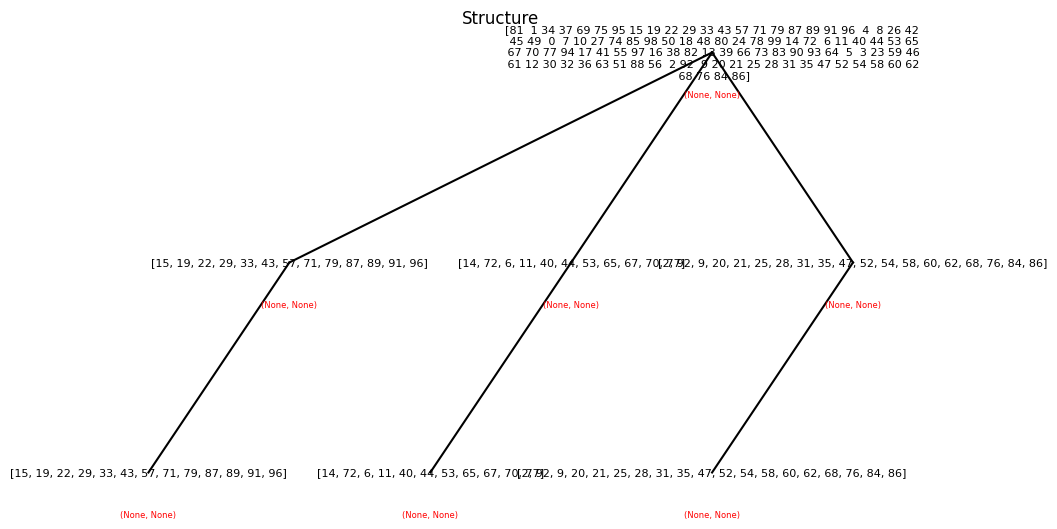

DEBUG:root:Retrieving all leaf nodes from the DyadicTree
DEBUG:root:Found 3 leaf nodes


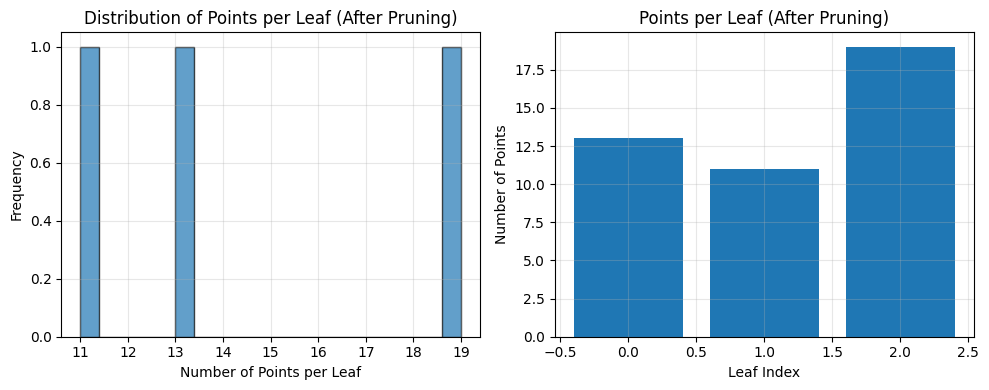

All remaining leaves have >= 10 points: True


In [12]:
# Visualize the pruned tree structure
print("Visualizing the pruned tree:")
dyadic_sklearn.plot_tree()

# Show histogram of point counts per remaining leaf
remaining_leafs = dyadic_sklearn.get_all_leafs()
if remaining_leafs:
    remaining_counts = [len(leaf.idxs) for leaf in remaining_leafs]
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(remaining_counts, bins=20, alpha=0.7, edgecolor='black')
    plt.xlabel('Number of Points per Leaf')
    plt.ylabel('Frequency')
    plt.title('Distribution of Points per Leaf (After Pruning)')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.bar(range(len(remaining_counts)), remaining_counts)
    plt.xlabel('Leaf Index')
    plt.ylabel('Number of Points')
    plt.title('Points per Leaf (After Pruning)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"All remaining leaves have >= {min_points} points: {all(count >= min_points for count in remaining_counts)}")
else:
    print("No leaves remaining to visualize.")

In [13]:
# for each leaf, print number of points, plot histogram of point counts per leaf

for leaf in dyadic_sklearn.get_all_leafs():
    logging.debug(f"Leaf j={leaf.node_j}, k={leaf.node_k}, points={len(leaf.idxs)}")

DEBUG:root:Retrieving all leaf nodes from the DyadicTree
DEBUG:root:Found 3 leaf nodes
DEBUG:root:Leaf j=None, k=None, points=13
DEBUG:root:Leaf j=None, k=None, points=11
DEBUG:root:Leaf j=None, k=None, points=19


In [14]:
dyadic_sklearn.fit(X_demo)

INFO:root:Starting basis construction for DyadicTree
DEBUG:root:Computing basis for node (j=0, k=0) with 100 points, is_leaf=False
DEBUG:root:Node (j=0, k=0) basis shape: (100, 784), sigmas: 101
DEBUG:root:Processing level 1 with 3 children
DEBUG:root:Computing basis for node (j=1, k=0) with 13 points, is_leaf=False
DEBUG:root:Node (j=1, k=0) basis shape: (13, 784), sigmas: 14
DEBUG:root:Processing level 2 with 1 children
DEBUG:root:Computing basis for node (j=2, k=0) with 13 points, is_leaf=True
DEBUG:root:Node (j=2, k=0) basis shape: (12, 784), sigmas: 14
DEBUG:root:Computing basis for node (j=1, k=1) with 11 points, is_leaf=False
DEBUG:root:Node (j=1, k=1) basis shape: (11, 784), sigmas: 12
DEBUG:root:Processing level 2 with 1 children
DEBUG:root:Computing basis for node (j=2, k=1) with 11 points, is_leaf=True
DEBUG:root:Node (j=2, k=1) basis shape: (10, 784), sigmas: 12
DEBUG:root:Computing basis for node (j=1, k=2) with 19 points, is_leaf=False
DEBUG:root:Node (j=1, k=2) basis sha

info: making wavelets


DEBUG:root:Making transform for node 1/1 at level 0


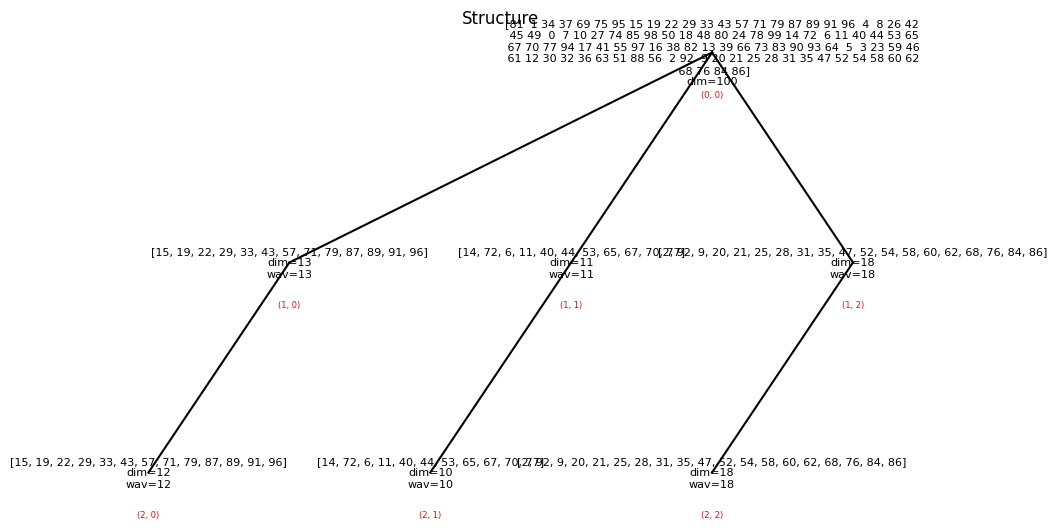

In [24]:
# plot the tree after fit basis
dyadic_sklearn.plot_tree(show_basis_dim=True)

In [26]:
feat, leafjk = dyadic_sklearn.fgwt(X_demo)

DEBUG:root:Starting forward GMRA wavelet transform for 100 data points


KeyError: 0

In [16]:
feat = dyadic_sklearn.fgwt_batch(X_demo)

DEBUG:root:Retrieving all leaf nodes from the DyadicTree
DEBUG:root:Found 3 leaf nodes
DEBUG:root:Found 3 leaf nodes for batch processing
DEBUG:root:['(j=2, k=0)', '(j=2, k=1)', '(j=2, k=2)']
DEBUG:root:Processed leaf (j=2, k=0)
DEBUG:root:Processed node (j=1, k=0), pjx shape: (100, 13), qjx shape: (100, 13)
DEBUG:root:Processed leaf (j=2, k=1)


DEBUG:root:Processed node (j=1, k=1), pjx shape: (100, 11), qjx shape: (100, 11)
DEBUG:root:Processed leaf (j=2, k=2)
DEBUG:root:Processed node (j=1, k=2), pjx shape: (100, 18), qjx shape: (100, 18)


In [17]:
feat.shape

(100, 382)

In [18]:
inv, inv_each = dyadic_sklearn.igwt_batch(feat,  None, None)

DEBUG:root:Retrieving all leaf nodes from the DyadicTree
DEBUG:root:Found 3 leaf nodes
DEBUG:root:Found 3 leaf nodes for batch processing
DEBUG:root:['(j=2, k=0)', '(j=2, k=1)', '(j=2, k=2)']
DEBUG:root:Processing leaf (j=2, k=0)
DEBUG:root:Multiplying jk (j=2, k=0),                with coeff from dimension 0 to 12
DEBUG:root:Multiplying node (j=1, k=0),                    with coeff from dimension 12 to 25
DEBUG:root:Multiplying root (j=0, k=0),                with coeff from dimension 25 to 125


DEBUG:root:Processing leaf (j=2, k=1)
DEBUG:root:Multiplying jk (j=2, k=1),                with coeff from dimension 125 to 135
DEBUG:root:Multiplying node (j=1, k=1),                    with coeff from dimension 135 to 146
DEBUG:root:Multiplying root (j=0, k=0),                with coeff from dimension 146 to 246
DEBUG:root:Processing leaf (j=2, k=2)
DEBUG:root:Multiplying jk (j=2, k=2),                with coeff from dimension 246 to 264
DEBUG:root:Multiplying node (j=1, k=2),                    with coeff from dimension 264 to 282
DEBUG:root:Multiplying root (j=0, k=0),                with coeff from dimension 282 to 382


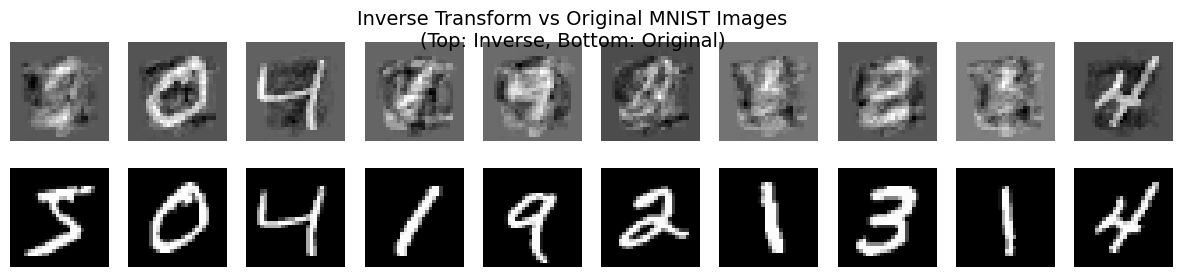

In [19]:
# visualize inv vs X_demo
inv_images = inv_each[2].reshape(-1, 28, 28)
X_demo_images = X_demo.reshape(-1, 28, 28)

# Create subplot with 2 rows and 10 columns
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
fig.suptitle('Inverse Transform vs Original MNIST Images\n(Top: Inverse, Bottom: Original)', fontsize=14)

# Plot inverse images
for i in range(10):
    axes[0, i].imshow(inv_images[i], cmap='gray')
    axes[0, i].axis('off') 

# Plot original images
for i in range(10):
    axes[1, i].imshow(X_demo_images[i], cmap='gray')
    axes[1, i].axis('off')

plt.show()


In [20]:
dyadic_sklearn.root.is_leaf

False

In [21]:
# gmra using fgwt and igwt

X = X_demo.copy()
dtree = DyadicTree(
    cover_tree=cover_tree_demo,
    manifold_dims=0,      # Expected intrinsic dimension
    max_dim=X.shape[-1],  # Maximum basis dimension  
    thresholds=0,       # Thresholds for basis construction
    precisions=1e-2,      # Precision parameters
    inverse=True          # Data in (n,d) format
)

DEBUG:root:Building tree at level 1, node indices: [81  1 34 37 69 75 95 15 19 22 29 33 43 57 71 79 87 89 91 96  4  8 26 42
 45 49  0  7 10 27 74 85 98 50 18 48 80 24 78 99 14 72  6 11 40 44 53 65
 67 70 77 94 17 41 55 97 16 38 82 13 39 66 73 83 90 93 64  5  3 23 59 46
 61 12 30 32 36 63 51 88 56  2 92  9 20 21 25 28 31 35 47 52 54 58 60 62
 68 76 84 86]
DEBUG:root:Updated tree height to 2
DEBUG:root:Processing internal node at level 1 with 20 children
DEBUG:root:Created child 1/20 at level 1
DEBUG:root:Building tree at level 2, node indices: [81, 1, 34, 37, 69, 75, 95]
DEBUG:root:Updated tree height to 3
DEBUG:root:Created leaf node at level 2 with indices: [81, 1, 34, 37, 69, 75, 95]
DEBUG:root:Created child 2/20 at level 1
DEBUG:root:Building tree at level 2, node indices: [15, 19, 22, 29, 33, 43, 57, 71, 79, 87, 89, 91, 96]
DEBUG:root:Created leaf node at level 2 with indices: [15, 19, 22, 29, 33, 43, 57, 71, 79, 87, 89, 91, 96]
DEBUG:root:Created child 3/20 at level 1
DEBUG:root:B

In [22]:
dtree = dtree.fit(X)

INFO:root:Starting basis construction for DyadicTree
DEBUG:root:Computing basis for node (j=0, k=0) with 100 points, is_leaf=False


DEBUG:root:Node (j=0, k=0) basis shape: (100, 784), sigmas: 101
DEBUG:root:Processing level 1 with 20 children
DEBUG:root:Computing basis for node (j=1, k=0) with 7 points, is_leaf=False
DEBUG:root:Node (j=1, k=0) basis shape: (7, 784), sigmas: 8
DEBUG:root:Processing level 2 with 1 children
DEBUG:root:Computing basis for node (j=2, k=0) with 7 points, is_leaf=True
DEBUG:root:Node (j=2, k=0) basis shape: (6, 784), sigmas: 8
DEBUG:root:Computing basis for node (j=1, k=1) with 13 points, is_leaf=False
DEBUG:root:Node (j=1, k=1) basis shape: (13, 784), sigmas: 14
DEBUG:root:Processing level 2 with 1 children
DEBUG:root:Computing basis for node (j=2, k=1) with 13 points, is_leaf=True
DEBUG:root:Node (j=2, k=1) basis shape: (12, 784), sigmas: 14
DEBUG:root:Computing basis for node (j=1, k=2) with 5 points, is_leaf=False
DEBUG:root:Node (j=1, k=2) basis shape: (5, 784), sigmas: 6
DEBUG:root:Processing level 2 with 1 children
DEBUG:root:Computing basis for node (j=2, k=2) with 5 points, is_le

info: making wavelets


DEBUG:root:Making transform for node 20/20 at level 1
DEBUG:root:Processing wavelets for level 0 with 1 nodes
DEBUG:root:Making transform for node 1/1 at level 0


In [23]:
z,q = dtree.fgwt(X)

DEBUG:root:Starting forward GMRA wavelet transform for 100 data points


KeyError: 0

In [ ]:
x_recon = dtree.igwt(z, q, X.shape)

NameError: name 'z' is not defined

In [ ]:
# plot x vs x_recon as mnist images

X_recon_images = x_recon.reshape(-1, 28, 28)
X_demo_images = X.reshape(-1, 28, 28)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_demo_images[i], cmap='gray')
    plt.axis('off')
    plt.subplot(2, 10, i + 11)
    plt.imshow(X_recon_images[i], cmap='gray')
    plt.axis('off')
plt.show()

NameError: name 'x_recon' is not defined

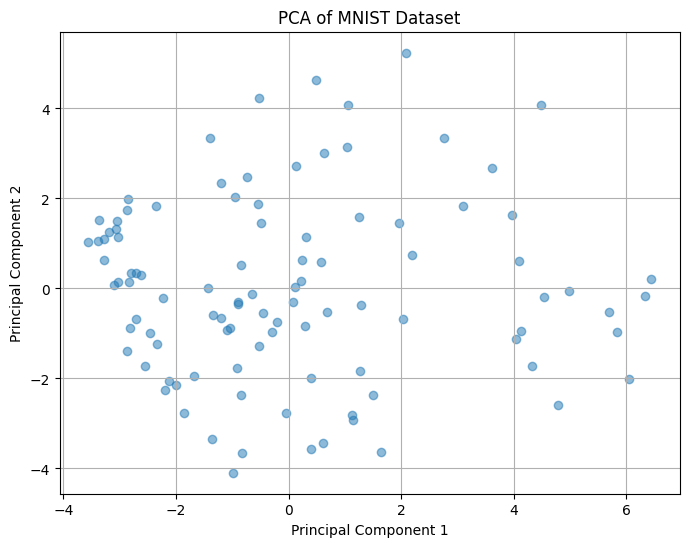

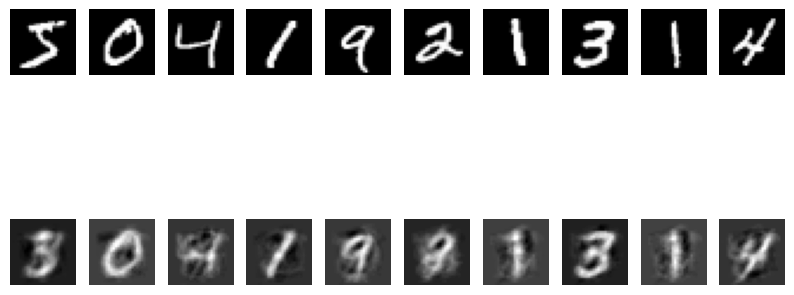

In [ ]:
# experimenttal, compute PCA for dataset and reconscutr

from sklearn.decomposition import PCA
pca = PCA(n_components=10)  # Use all components for reconstruction
X_pca = pca.fit_transform(X_demo)
# Plot PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('PCA of MNIST Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Reconstruct using PCA
X_pca_recon = pca.inverse_transform(X_pca)
# Plot PCA reconstruction
X_pca_recon_images = X_pca_recon.reshape(-1, 28, 28)

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_demo_images[i], cmap='gray')
    plt.axis('off')
    plt.subplot(2, 10, i + 11)
    plt.imshow(X_pca_recon_images[i], cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
# create a nxn orthogonal matrix
n = 10
Q = np.random.randn(n, n)
Q, _ = np.linalg.qr(Q)  # QR decomposition to get orthogonal matrix

In [ ]:
Q.shape

(10, 10)

In [ ]:
Qs = Q[:,:5]

In [ ]:
Qs @ Qs.T

array([[ 0.31402666, -0.01434832, -0.12409435, -0.37170645, -0.12706248,
        -0.17960651,  0.0586904 , -0.06846365, -0.06139706,  0.03658063],
       [-0.01434832,  0.31767283, -0.25883714, -0.07656368,  0.12057149,
         0.23203143, -0.15281414, -0.04229396,  0.14650246,  0.16944699],
       [-0.12409435, -0.25883714,  0.77624056, -0.00139669,  0.07355507,
        -0.12781756, -0.10978677, -0.16639817,  0.16961195, -0.03218316],
       [-0.37170645, -0.07656368, -0.00139669,  0.62144856,  0.14566579,
         0.0874613 ,  0.13145267,  0.13418062, -0.16424909,  0.00951845],
       [-0.12706248,  0.12057149,  0.07355507,  0.14566579,  0.25782674,
         0.02440369, -0.10237319, -0.11302663, -0.01840926,  0.33143801],
       [-0.17960651,  0.23203143, -0.12781756,  0.0874613 ,  0.02440369,
         0.42053855,  0.0126807 , -0.00201293,  0.34509768, -0.11725691],
       [ 0.0586904 , -0.15281414, -0.10978677,  0.13145267, -0.10237319,
         0.0126807 ,  0.85972789, -0.22474801